# Milestone 1:  Simple Vizualizations

## Args

In [1]:
cleaned_data_dir = "./data/cleaned/"

## Dependencies

In [9]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Setup

In [10]:
pwd

'/home/jake/Projects/mila/6758/hockey'

In [11]:
plt.style.use('ggplot')

In [25]:
team_files = os.listdir(cleaned_data_dir)

plays = pd.concat([pd.read_csv(os.path.join(cleaned_data_dir, team_file)) for team_file in team_files])
plays = plays.drop("Unnamed: 0", axis=1)
plays.shape

(385076, 29)

In [31]:
plays['season'] = plays['game_id'].apply(lambda gid: int(str(gid)[:4]))

In [71]:
plays = plays[plays['coordinate_x'] >= 25]  # only consider shots within offensive zone (25 = blue line coordinate)
plays = plays[~plays['is_empty_net'].fillna(False)]  # remove empty net situations
plays = plays[plays['period_type'] != 'SHOOTOUT']  # remove shootout situations
plays = plays[plays['season'] >= 2018]
plays.shape

(203928, 32)

## Q1: Shot Types

In [72]:
outcomes_by_shot_type_2017 = plays[plays['season']==2018].groupby(['type','secondary_type']).size().reset_index()
outcomes_by_shot_type_2017.columns = ['type', 'secondary_type', 'total']

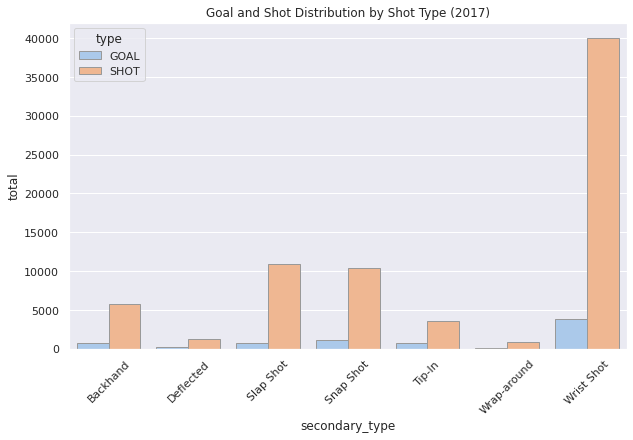

In [73]:
sns.set(rc={'figure.figsize':(10,6)})
sns.barplot(x='secondary_type', y='total', hue='type', data=outcomes_by_shot_type_2017,
            palette="pastel", edgecolor=".6")

plt.title("Goal and Shot Distribution by Shot Type (2017)");
plt.xticks(rotation=45);

In [74]:
outcomes_by_shot_type_2017 = outcomes_by_shot_type_2017.pivot("secondary_type", "type", "total")
outcomes_by_shot_type_2017['goal_pct'] = \
    outcomes_by_shot_type_2017['GOAL'] / \
    (outcomes_by_shot_type_2017['GOAL'] + outcomes_by_shot_type_2017['SHOT'])

outcomes_by_shot_type_2017.sort_values('goal_pct', ascending=False)

type,GOAL,SHOT,goal_pct
secondary_type,,,
Tip-In,761,3547,0.176648
Deflected,263,1286,0.169787
Backhand,741,5803,0.113233
Snap Shot,1155,10406,0.099905
Wrist Shot,3854,39999,0.087885
Wrap-around,60,824,0.067873
Slap Shot,768,10955,0.065512


>(According to an NHL spokesperson, there is a clear difference between a tip and a deflection. Tips are off an offensive player’s stick; deflections are off other extensions of the player, such as gear or a body part.)

Shot-level data from the 2017 makes it clear that tips (intentional redirections of one player's shot by another) and deflections (unintentional redirections) are very dangerous situations for defending teams.

As expected, snap and wrist shots are the most common shot types. This makes sense because both types can be easily disguised from defending goaltenders -- snap shots require no prior adjustment of the player's hold on the stick, while wrist shots look similar to passes until the moment they are released.

## Q2: Goal by Distance

In [75]:
STANDARDIZED_GOAL_COORDINATES = (89, 0)

In [76]:
plays['distance'] = ((STANDARDIZED_GOAL_COORDINATES[0] - plays['coordinate_x'])**2 \
                               + (STANDARDIZED_GOAL_COORDINATES[1] - plays['coordinate_y'])**2)**(.5)

plays['distance'] = plays['distance'].round()

In [77]:
plays['distance_bin'] = ((plays['distance'] // 2) * 2)  # binning:  rounds down to nearest even number

In [78]:
outcomes_by_distance = plays.groupby(['season', 'distance_bin', 'type']).size().reset_index()
outcomes_by_distance.columns = ['season', 'distance_bin', 'type', 'total']

outcomes_by_distance = outcomes_by_distance.pivot(["season", "distance_bin"], "type", "total")
outcomes_by_distance = outcomes_by_distance.reset_index()  # for seaborn


In [82]:
outcomes_by_distance['ATTEMPTS'] = (outcomes_by_distance['GOAL'] + outcomes_by_distance['SHOT'])

outcomes_by_distance = outcomes_by_distance[outcomes_by_distance['ATTEMPTS'] >= 25]

In [83]:
outcomes_by_distance['goal_pct'] = outcomes_by_distance['GOAL'] / outcomes_by_distance['ATTEMPTS']

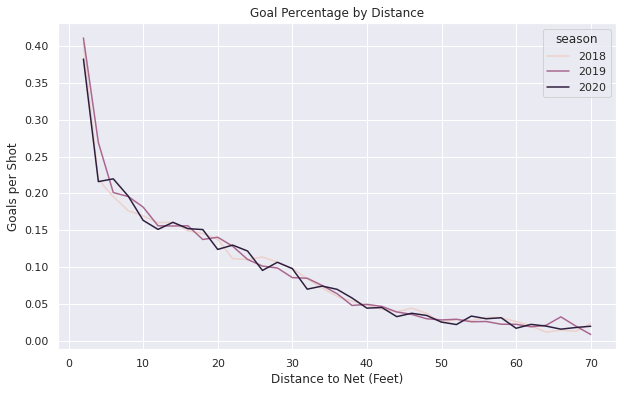

In [85]:
sns.lineplot(x="distance_bin", y="goal_pct", hue="season", data=outcomes_by_distance)
plt.title(f"Goal Percentage by Distance");
plt.xlabel("Distance to Net (Feet)");
plt.ylabel("Goals per Shot");

Note: Excludes shootouts, empty net situations, and shots from outside the offensive zone.

## Q3:  Putting it Together

In [97]:
outcomes_by_shot = plays.groupby(['distance_bin', 'type', 'secondary_type'])\
                        .size().reset_index()
outcomes_by_shot.columns = ['distance_bin', 'type', 'shot_type', 'total']

outcomes_by_shot = outcomes_by_shot.pivot(["shot_type", "distance_bin"], "type", "total")
outcomes_by_shot = outcomes_by_shot.reset_index()  # for seaborn

outcomes_by_shot['ATTEMPTS'] = (outcomes_by_shot['GOAL'] + outcomes_by_shot['SHOT'])
outcomes_by_shot['goal_pct'] = outcomes_by_shot['GOAL'] / outcomes_by_shot['ATTEMPTS']

outcomes_by_shot = outcomes_by_shot[outcomes_by_shot['ATTEMPTS'] >= 25]


In [99]:
# filter out sparse tails
outcomes_by_shot = \
    outcomes_by_shot[((outcomes_by_shot['shot_type']=='Backhand') & \
                      (outcomes_by_shot['distance_bin'] <= 40)) |
                     ((outcomes_by_shot['shot_type']=='Deflected') & \
                      (outcomes_by_shot['distance_bin'] <= 32)) |
                      ((outcomes_by_shot['shot_type']=='Snap Shot') & \
                      (outcomes_by_shot['distance_bin'] <= 64)) |
                      ((outcomes_by_shot['shot_type']=='Tip-In') & \
                      (outcomes_by_shot['distance_bin'] <= 30)) |
                      ((outcomes_by_shot['shot_type']=='Slap Shot'))]

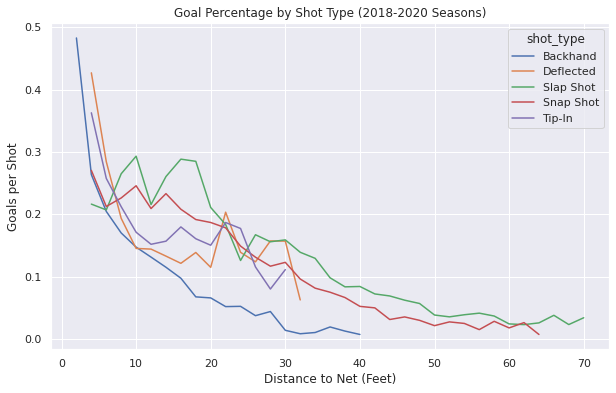

In [101]:
sns.lineplot(x="distance_bin", y="goal_pct", hue="shot_type", data=outcomes_by_shot)
plt.title(f"Goal Percentage by Shot Type (2018-2020 Seasons)");
plt.xlabel("Distance to Net (Feet)");
plt.ylabel("Goals per Shot");

Note: Excludes shootouts, empty net situations, and shots from outside the offensive zone.

## Bonus

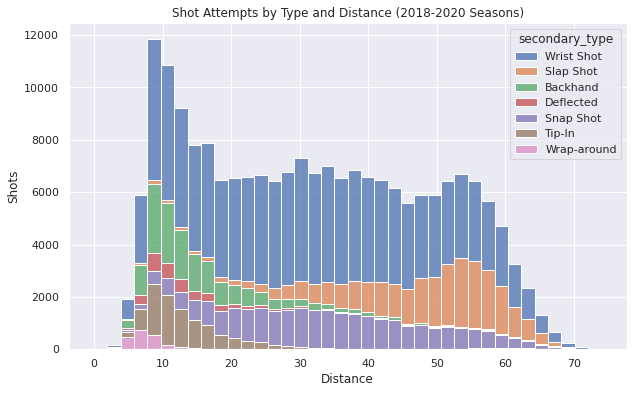

In [103]:
goals = plays[(plays['type']=='GOAL')].reset_index()
sns.histplot(x='distance_bin', hue='secondary_type', multiple='stack', data=plays.reset_index(), bins=76//2);
plt.title("Shot Attempts by Type and Distance (2018-2020 Seasons)");
plt.xlabel("Distance");
plt.ylabel("Shots");